In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/densenet169/other/default/1/densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026412.jpg
/kaggle/input/skin-cancer-mnist-

In [1]:
base='/kaggle/input/skin-cancer-mnist-ham10000'

In [2]:
#IMPORT NECESSARY LIBRARIES

import os
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet169, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


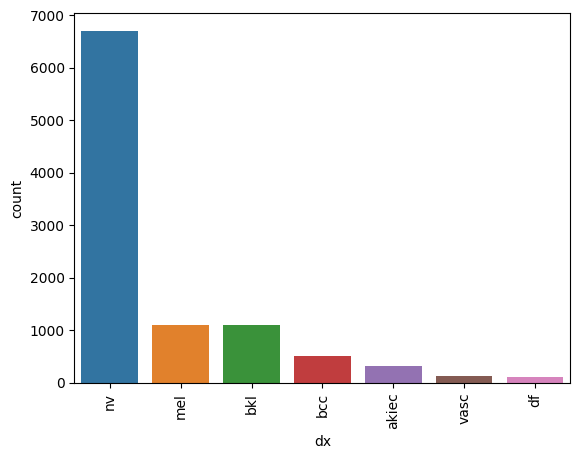

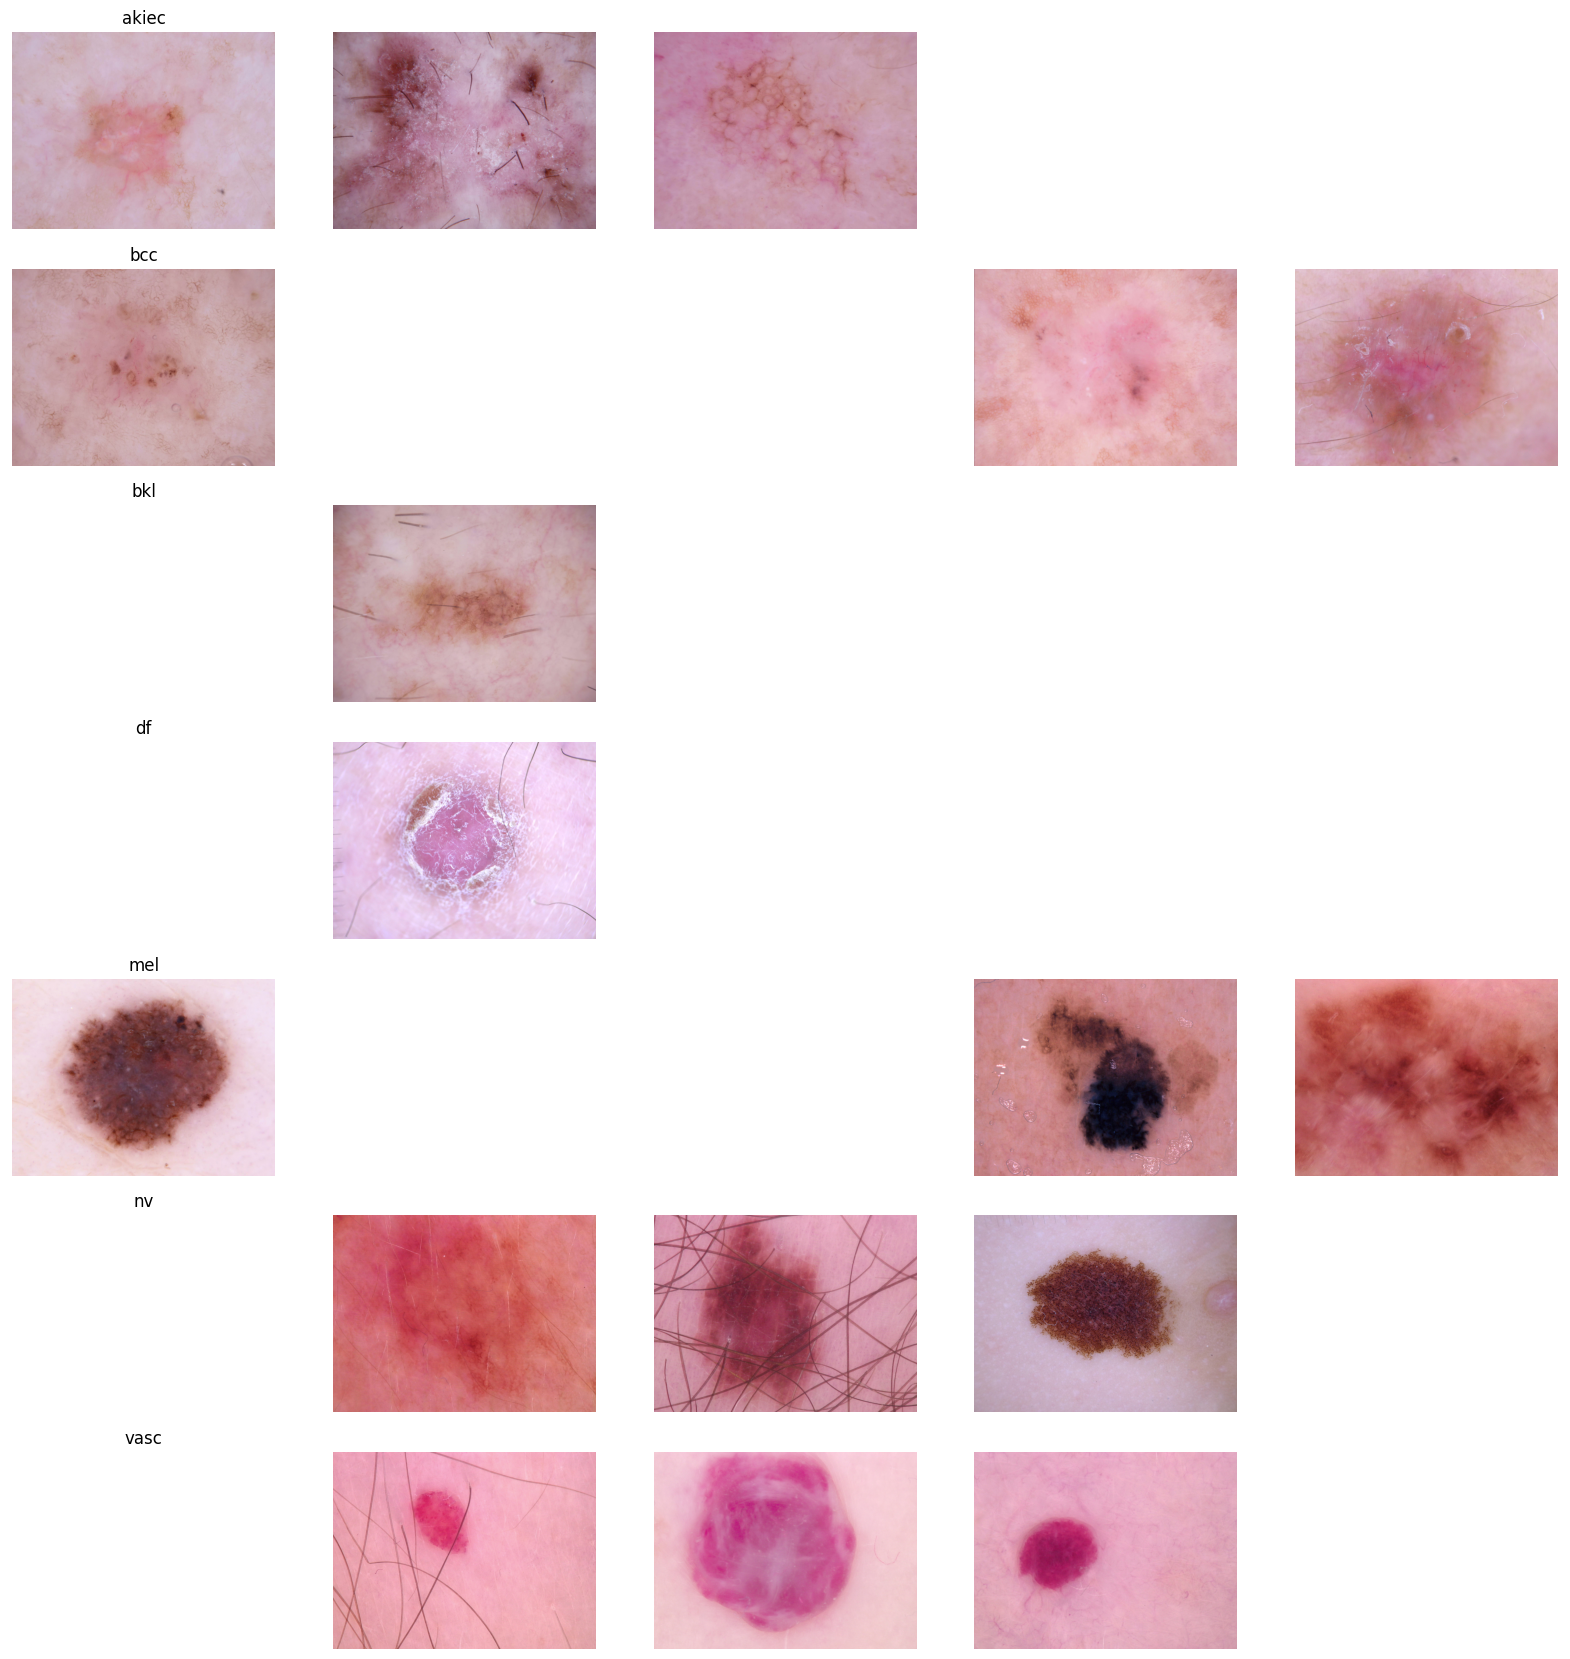

In [3]:
# Load the HAM10000 dataset and attach images

# Load metadata CSV
skin_df = pd.read_csv(os.path.join(base, 'HAM10000_metadata.csv'))
print(skin_df.info())

# Define image size (resize the images to 244*244)
image_size = 224

# Define image directory (all images are in this folder)
img_dir = os.path.join(base, 'HAM10000_images_part_1/')

# Function to load images and resize them
def load_images(dataframe, img_dir):
    images = []
    labels = []
    
    for index, row in dataframe.iterrows():
        img_path = os.path.join(img_dir, row['image_id'] + '.jpg')
        
        if os.path.exists(img_path):  # Check if image file exists
            img = cv2.imread(img_path)
            img = cv2.resize(img, (image_size, image_size))
            images.append(img)
            labels.append(row['dx'])  # 'dx' column contains the label
    
    return np.array(images), np.array(labels)

# Load images using metadata (meta) and image directory (img_dir)
X, y = load_images(skin_df, img_dir)

# Normalize the images (scale pixel values between 0 and 1)
X = X / 255.0

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, num_classes=7)  # Adjust the number of classes as needed

# Display the label distribution
print(skin_df['dx'].value_counts())

# Plot distribution of labels using seaborn
counts = skin_df['dx'].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xticks(rotation=90)
plt.show()

# Plot samples of images by label
n_samples = 5 
fig, m_axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))
for n_axs, (type_name, type_rows) in zip(m_axs, skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        img_path = os.path.join(img_dir, c_row['image_id'] + '.jpg')
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display
            c_ax.imshow(img)
        c_ax.axis('off')

plt.show()


In [4]:
#ORGANIZING IMAGES AND DIRECTORIES

# Define directories
base_dir = '/kaggle/input/skin-cancer-mnist-ham10000'
data_dir_1 = os.path.join(base_dir, 'HAM10000_images_part_1')
data_dir_2 = os.path.join(base_dir, 'HAM10000_images_part_2')
dest_dir = '/kaggle/working/ham10000_dataset'

# Create new dataset directories
train_dir = os.path.join(dest_dir, 'train')
val_dir = os.path.join(dest_dir, 'valid')
test_dir = os.path.join(dest_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Load metadata    
skin_df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))
labels = skin_df['dx'].unique().tolist()

# Combine all images into a single list
all_images = []
for img_id, label in zip(skin_df['image_id'], skin_df['dx']):
    img_path_1 = os.path.join(data_dir_1, img_id + '.jpg')
    img_path_2 = os.path.join(data_dir_2, img_id + '.jpg')
    img_path = img_path_1 if os.path.exists(img_path_1) else img_path_2 if os.path.exists(img_path_2) else None
    if img_path:
        all_images.append((img_path, label))

# Extract image paths and labels
image_paths, image_labels = zip(*all_images)

#Train-Test split

# First split: 80% training, 20% testing
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, image_labels, test_size=0.2, random_state=42, stratify=image_labels
)

# Second split: 80% of training for actual training, 20% for validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)
# Function to copy images to the new directory structure
def copy_images(image_list, label_list, dest_dir):
    for img_path, label in zip(image_list, label_list):
        class_dest = os.path.join(dest_dir, label)
        os.makedirs(class_dest, exist_ok=True)
        shutil.copy(img_path, class_dest)

# Copy train, validation, and test images
copy_images(train_paths, train_labels, train_dir)
copy_images(val_paths, val_labels, val_dir)
copy_images(test_paths, test_labels, test_dir)

print(f"Dataset split completed! Train: {len(train_paths)}, Validation: {len(val_paths)}, Test: {len(test_paths)}")

print(f"Dataset successfully split and stored at {dest_dir}")
print(f"Training data stored at: {train_dir}")
print(f"Validation data stored at: {val_dir}")
print(f"Test data stored at: {test_dir}")

Dataset split completed! Train: 6409, Validation: 1603, Test: 2003
Dataset successfully split and stored at /kaggle/working/ham10000_dataset
Training data stored at: /kaggle/working/ham10000_dataset/train
Validation data stored at: /kaggle/working/ham10000_dataset/valid
Test data stored at: /kaggle/working/ham10000_dataset/test


In [5]:
#DATA AUGMENTATION

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a single ImageDataGenerator with augmentation for training
data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=5,
    brightness_range=(0.85, 1.15),
    width_shift_range=0.02,
    height_shift_range=0.02,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest",
)

# Use the same generator for training and validation
train_generator = data_gen.flow_from_directory(
    directory="/kaggle/working/ham10000_dataset/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = data_gen.flow_from_directory(
    directory="/kaggle/working/ham10000_dataset/valid",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load test data with a separate generator to avoid augmentations
test_datagen = ImageDataGenerator(
    rescale=1. / 255
)

test_generator = test_datagen.flow_from_directory(
    directory="/kaggle/working/ham10000_dataset/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")


Found 6409 images belonging to 7 classes.
Found 1603 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.
Training samples: 6409
Validation samples: 1603
Test samples: 2003


In [6]:
#TEACHER MODELS

# Enable Mixed Precision for Faster Training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Enable XLA Compilation for Faster Execution
tf.config.optimizer.set_jit(True)

# Defining image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 7  # HAM10000 has 7 skin lesion classes
ALPHA = 0.8  # Distillation weight
TEMPERATURE = 30  # Higher for smoother soft labels

# Function to build a model
def build_model(base_model):
    base_model.trainable = False  # Freeze the pretrained layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(NUM_CLASSES, activation='softmax')(x)  # Multi-class classification
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build ResNet50 and DenseNet169 models
resnet_model = build_model(ResNet50(weights="/kaggle/input/resnet50/tensorflow2/default/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5", include_top=False, input_shape=(224, 224, 3)))
densenet_model = build_model(DenseNet169(weights="/kaggle/input/densenet169/other/default/1/densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5", include_top=False, input_shape=(224, 224, 3)))

# Train both models separately
resnet_model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)
densenet_model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


201/201 ━━━━━━━━━━━━━━━━━━━━ 150s 669ms/step - accuracy: 0.6543 - loss: 1.3157 - val_accuracy: 0.6694 - val_loss: 1.1299
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 128s 621ms/step - accuracy: 0.6638 - loss: 1.1516 - val_accuracy: 0.6694 - val_loss: 1.1248
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 128s 619ms/step - accuracy: 0.6680 - loss: 1.1230 - val_accuracy: 0.6706 - val_loss: 1.1055
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 128s 618ms/step - accuracy: 0.6718 - loss: 1.0971 - val_accuracy: 0.6694 - val_loss: 1.0845
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 128s 619ms/step - accuracy: 0.6654 - loss: 1.1219 - val_accuracy: 0.6719 - val_loss: 1.0831
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 127s 617ms/step - accuracy: 0.6722 - loss: 1.0887 - val_accuracy: 0.6744 - val_loss: 1.0758
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 128s 619ms/step - accuracy: 0.6813 - loss: 1.0424 - val_accuracy: 0.6731 - val_loss: 1.0683
Epoch 8/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 128s 620ms/step - accuracy: 0.6690 - loss: 1.09

In [7]:
#STUDENT MODEL

# Hyperparameters
ALPHA = 0.8  # Distillation weight
TEMPERATURE = 50  # Higher for smoother soft labels
EPOCHS = 20 
NUM_CLASSES = 7  # 7 skin cancer classes

# Function to Get Soft Labels from Teachers
def get_teacher_predictions(models, dataset):
    predictions = [model.predict(dataset) for model in models]
    return np.mean(predictions, axis=0)  # Average predictions for soft labels

# Generate Soft Labels for Training Student Model
soft_labels = get_teacher_predictions([resnet_model, densenet_model], train_generator)

# Define Student Model (Lightweight Model like MobileNetV2)
student_base = MobileNetV2(weights=None, include_top=False, input_shape=(224, 224, 3))
x = student_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)  
x = Dropout(0.3)(x)  
x = Dense(NUM_CLASSES, activation='softmax')(x)
student_model = Model(inputs=student_base.input, outputs=x)

class DistillationModel(tf.keras.Model):
    def train_step(self, data):
        x, y_true = data
        batch_size = tf.shape(y_true)[0]
        batch_indices = tf.range(batch_size)

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            teacher_pred = tf.gather(soft_labels, batch_indices)
            
            # Compute Distillation Loss
            soft_loss = tf.keras.losses.KLDivergence()(tf.nn.softmax(teacher_pred / TEMPERATURE), tf.nn.softmax(y_pred / TEMPERATURE))
            hard_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
            loss = ALPHA * soft_loss + (1 - ALPHA) * hard_loss

        # Compute gradients and update weights
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # Update model metrics (Fixes the error)
        self.compiled_metrics.update_state(y_true, y_pred)
        return {"loss": loss, **{m.name: m.result() for m in self.metrics}}

# Instantiate and Compile Student Model
student_model = DistillationModel(inputs=student_base.input, outputs=x)
student_model.compile(optimizer='adam', loss=lambda y_true, y_pred: 0, metrics=['accuracy'])

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train Student Model with Callbacks
history=student_model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=[early_stopping, reduce_lr])

# Save the Model
student_model.save("student_model_mobilenet.h5")

# Evaluate Student Model
accuracy = student_model.evaluate(val_generator)[1]
print(f"Student Model Accuracy: {accuracy * 100:.2f}%")

201/201 ━━━━━━━━━━━━━━━━━━━━ 107s 517ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 124s 556ms/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:592: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


201/201 ━━━━━━━━━━━━━━━━━━━━ 228s 822ms/step - accuracy: 0.4114 - loss: 0.1429 - val_accuracy: 0.6694 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 127s 614ms/step - accuracy: 0.6370 - loss: 0.1429 - val_accuracy: 0.6694 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 127s 613ms/step - accuracy: 0.6755 - loss: 0.1429 - val_accuracy: 0.6694 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 127s 614ms/step - accuracy: 0.6945 - loss: 0.1429 - val_accuracy: 0.6694 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 129s 623ms/step - accuracy: 0.6817 - loss: 0.1429 - val_accuracy: 0.6694 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 129s 622ms/step - accuracy: 0.6851 - loss: 0.1429 - val_accuracy: 0.6694 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 129s 625ms/

In [8]:
train_loss, train_acc = student_model.evaluate(train_generator)
print(f"Training Accuracy: {train_acc * 100:.2f}%")

201/201 ━━━━━━━━━━━━━━━━━━━━ 104s 517ms/step - accuracy: 0.6667 - loss: 0.0000e+00
Training Accuracy: 66.95%


In [9]:
#Test accuracy for real-world performance

test_loss, test_accuracy = student_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - accuracy: 0.3322 - loss: 0.0000e+00
Test Accuracy: 66.95%


In [10]:
#validation accuracy

val_loss, val_accuracy = student_model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 500ms/step - accuracy: 0.3388 - loss: 0.0000e+00
Validation Accuracy: 66.94%


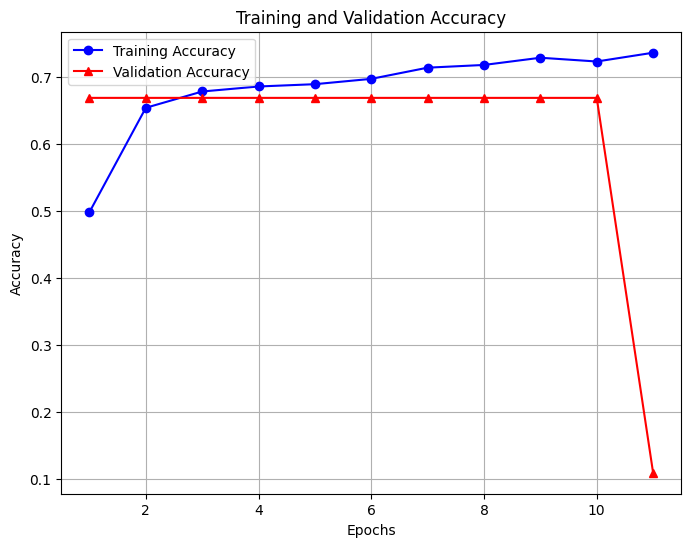

In [71]:
#TRAINING AND VALIDATION ACCURACY GRAPH

# Extract accuracy and validation accuracy from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)  # Number of epochs

# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')  # Blue line with dots
plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')  # Red line with triangles
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [13]:
#FINAL ACCURACIES

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Final Training Accuracy: 0.7368
Final Validation Accuracy: 0.1098
Final Training Loss: 0.1429
Final Validation Loss: 0.0000


In [14]:
#CLASSIFICATION REPORT

# Predict class probabilities on the validation set
y_pred_probs = student_model.predict(val_generator)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from the validation generator
y_true = val_generator.classes

# Print classification report
class_labels = list(val_generator.class_indices.keys())  # Assuming val_generator is the generator
print(classification_report(y_true, y_pred, target_names=class_labels))


51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 543ms/step
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        53
         bcc       0.00      0.00      0.00        82
         bkl       0.00      0.00      0.00       176
          df       0.00      0.00      0.00        18
         mel       0.00      0.00      0.00       178
          nv       0.67      1.00      0.80      1073
        vasc       0.00      0.00      0.00        23

    accuracy                           0.67      1603
   macro avg       0.10      0.14      0.11      1603
weighted avg       0.45      0.67      0.54      1603



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


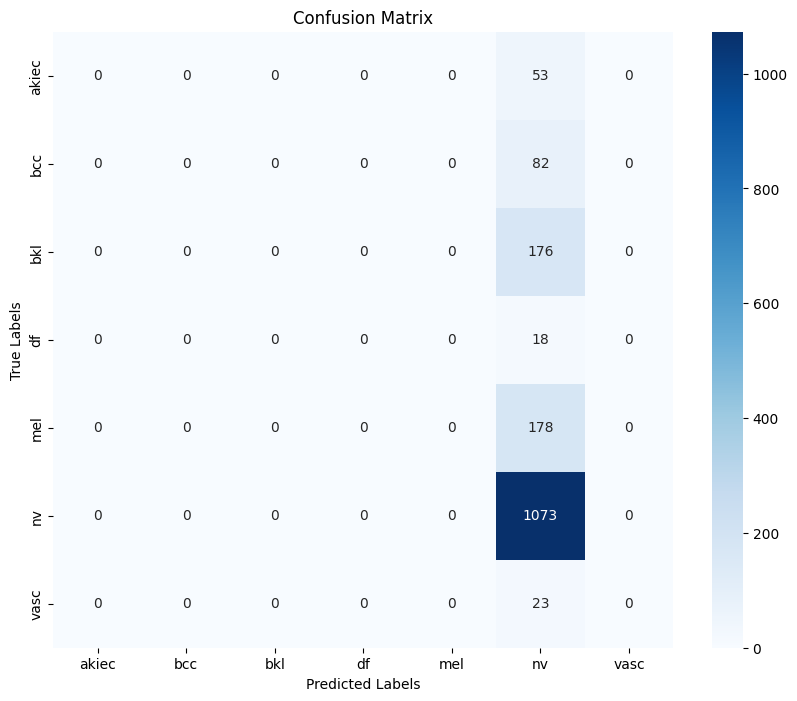

In [15]:
#CONFUSION MATRIX

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

✅ Model successfully rebuilt and weights loaded!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


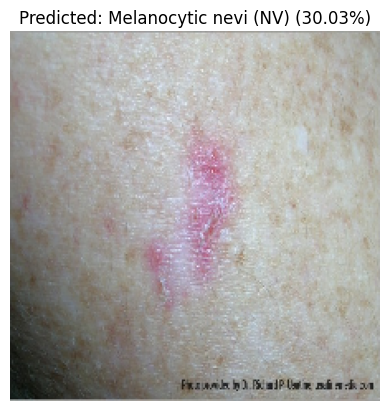

Detected Skin Cancer Type: Melanocytic nevi (NV) (Confidence: 30.03%)


In [72]:
#IMPLEMENTATION OF THE MODEL

from tensorflow.keras.preprocessing import image

# Define Hyperparameters (Matching the training setup)
NUM_CLASSES = 7  # 7 skin cancer types

# Rebuild Student Model (Same as training)
student_base = MobileNetV2(weights=None, include_top=False, input_shape=(224, 224, 3))

x = student_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)  
x = Dropout(0.3)(x)  
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

student_model = Model(inputs=student_base.input, outputs=output_layer)

# Custom Distillation Class (Same as training)
class DistillationModel(tf.keras.Model):
    def train_step(self, data):
        x, y_true = data
        y_pred = self(x, training=True)
        loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
        gradients = tf.GradientTape().gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(y_true, y_pred)
        return {"loss": loss, **{m.name: m.result() for m in self.metrics}}

# Wrap model with distillation class (NEEDED to load weights)
student_model = DistillationModel(inputs=student_base.input, outputs=output_layer)

# Compile (Loss is set to zero since it's only needed for training)
student_model.compile(optimizer='adam', loss=lambda y_true, y_pred: 0, metrics=['accuracy'])

# Load Trained Weights
student_model.load_weights("/kaggle/working/student_model_mobilenet.h5")

print("✅ Model successfully rebuilt and weights loaded!")

# Define class labels for HAM10000 dataset
CLASS_LABELS = {
    0: "Actinic keratoses (AKIEC)",
    1: "Basal cell carcinoma (BCC)",
    2: "Benign keratosis-like lesions (BKL)",
    3: "Dermatofibroma (DF)",
    4: "Melanoma (MEL)",
    5: "Melanocytic nevi (NV)",
    6: "Vascular lesions (VASC)"
}

def predict_skin_cancer(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = student_model.predict(img_array)[0]  
    predicted_class = np.argmax(prediction)  
    confidence = np.max(prediction) * 100  

    # Display result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {CLASS_LABELS[predicted_class]} ({confidence:.2f}%)")
    plt.show()

    return CLASS_LABELS[predicted_class], confidence

image_path = "/kaggle/input/melanoma-image/melanoma_image.jpeg"  
predicted_type, confidence_score = predict_skin_cancer(image_path)

print(f"Detected Skin Cancer Type: {predicted_type} (Confidence: {confidence_score:.2f}%)")



In [ ]:
# Create the Gradio interface
interface = gr.Interface(
    fn=predict_skin_cancer,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Label(label="Predicted Class"), gr.JSON(label="Confidence Scores")],
    title="Skin Cancer Detection",
    description="Upload an image to detect whether the lesion is benign or malignant."
)

# Launch the Gradio app
interface.launch(debug=True)